# Sentiment Analyzer NLP Project

### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.utils import resample


from wordcloud import WordCloud

import os
import gdown

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Download the Amazon Fine foods reviews dataset if not downloaded

In [3]:
url = 'https://drive.google.com/uc?export=download&id=1gy_xg86ieyPvzx5MSwJjKzvC_cp7CUcv'
output = 'reviews_dataset.csv'

if not os.path.exists(output):
    print(f"{output} does not exist. Downloading...")
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} already exists. Skipping download.")



reviews_dataset.csv already exists. Skipping download.


### Load the data set 

In [4]:
data = pd.read_csv('reviews_dataset.csv')

# dataset overview
print(data.shape)
print(data['Score'].value_counts())

(568454, 10)
Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64


#### Label Data

In [5]:
# remove neutral reviews -- score == 3
data = data[data['Score'] != 3]

# label
data['Positivity'] = np.where(data['Score'] > 3, 1, 0)

# overview the labeled data
print(data['Positivity'].value_counts())

Positivity
1    443777
0     82037
Name: count, dtype: int64


### Downsample the positive reviews (majority class)

In [6]:
data_majority = data[data['Positivity'] == 1]
data_minority = data[data['Positivity'] == 0]


data_majority_downsampled = resample(data_majority, 
                                     replace=False,    
                                     n_samples=len(data_minority), 
                                     random_state=42) 

data = pd.concat([data_minority, data_majority_downsampled])

# check data proportion
print(data['Positivity'].value_counts())

Positivity
0    82037
1    82037
Name: count, dtype: int64


### Optimize memory by dropping unneccessary columns

In [7]:
data = data.drop(['ProductId','UserId','ProfileName','Id','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time','Summary'], axis=1)
print(data.shape)

(164074, 2)


### Split Dataset into training and testing

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Positivity'], random_state = 0)


### Feature Extraction and Bag-of-words Transformation

<pre> Handling Infrequency </pre>
 Include only those words that appear in at least 5 documents in the vocabulary.

<pre> N-grams </pre>
make the vectorizer consider unigrams (single words), bigrams (two consecutive words), and trigrams (three consecutive words).

In [9]:
vect = CountVectorizer(min_df = 5, ngram_range = (1,3)).fit(X_train)
X_train_vectorized = vect.transform(X_train)

### Word Frequency with Word cloud

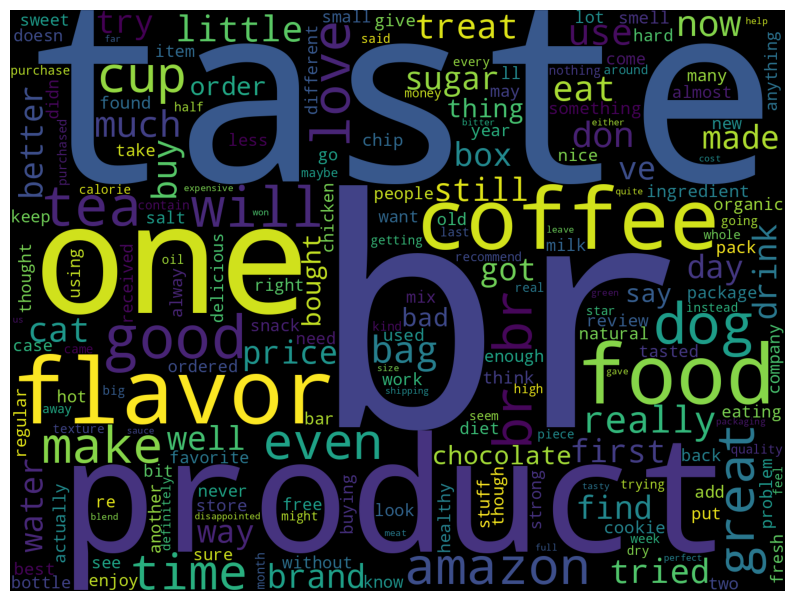

In [10]:
feat = vect.get_feature_names_out()
cloud = WordCloud(width=1440, height=1080).generate(" ".join(feat))

plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
plt.show()

### Train the model

In [11]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))
print("Accuracy: ",accuracy_score(y_test, predictions))


/home/kaleb/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.9452936444086887


###  Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Assessing the performance of our binary classification model using logistic regression

AUC:  0.9452885351410331


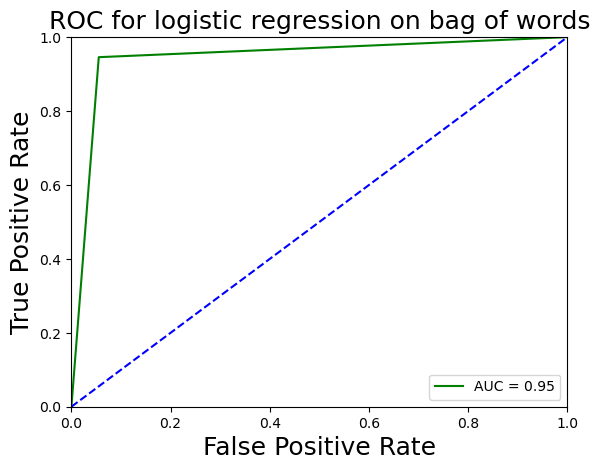

In [12]:
roc_auc = roc_auc_score(y_test, predictions)
print('AUC: ', roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, predictions)

plt.title('ROC for logistic regression on bag of words', fontsize=18)
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.show()

### Top ten words from each class

In [13]:
feature_names = np.array(vect.get_feature_names_out())

# argsort: Integer indicies that would sort the index if used as an indexer
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['terrible' 'disappointment' 'two stars' 'not worth' 'not good' 'awful'
 'disappointing' 'worst' 'unfortunately' 'very disappointed']

Largest Coefs: 
['delicious' 'excellent' 'hooked' 'not too' 'perfect' 'amazing'
 'love this' 'wonderful' 'be disappointed' 'highly recommend']



### Save the model and vectorizer for use with ui

In [14]:
with open('model.pkl', 'wb') as model_file, open('vectorizer.pkl', 'wb') as vect_file:
    pickle.dump(model, model_file)
    pickle.dump(vect, vect_file)

### Testing with Custom Input

In [15]:
new_review = ['The food was delicious', 'not bad at all', 'worse','best','great','bad']
print()
discrete = model.predict(vect.transform(new_review))
probabilities = model.predict_proba(vect.transform(new_review))

for review, ans, probability in zip(new_review, discrete, probabilities):
    print( f'The review {review} :  {ans} : is positive with probability {probability[1]} ')


The review The food was delicious :  1 : is positive with probability 0.8409080970125787 
The review not bad at all :  1 : is positive with probability 0.8099150801656102 
The review worse :  0 : is positive with probability 0.2178028003898943 
The review best :  1 : is positive with probability 0.749587980787962 
The review great :  1 : is positive with probability 0.8436612935018742 
The review bad :  0 : is positive with probability 0.2874229119157072 
